# Word Embedding using tensorflow keras

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import csv
import nltk
import io

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

from nltk.cluster import KMeansClusterer
from nltk.tokenize import word_tokenize

from sklearn import cluster
from sklearn import metrics

from tensorflow.keras.preprocessing.text import one_hot
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Création d'un réseau de neurones à partir de vecteurs de mots

In [2]:
vocab_size = 1000
embedding_dim = 16
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_portion = .8

### Récupérer nos données

In [3]:
data = pd.read_csv("my_csv_clean.csv",sep = ',') #we got that csv after running the Text Preprocessing file
data.columns = ['tweet', 'class']
    
X = data['tweet']
y = data['class'] 

categories = ["NotSexist", "Sexist"]

X_train, X_test, y_train , y_test = train_test_split(X , y ,test_size=0.3)

X = list(X)
y = [categories[i] for i in y]
X_train = list(X_train)
X_test = list(X_test)
y_train = [categories[i] for i in y_train]
y_test = [categories[i] for i in y_test]
print(y_train)

['NotSexist', 'Sexist', 'NotSexist', 'Sexist', 'Sexist', 'NotSexist', 'Sexist', 'Sexist', 'Sexist', 'NotSexist', 'NotSexist', 'NotSexist', 'Sexist', 'Sexist', 'NotSexist', 'Sexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'Sexist', 'NotSexist', 'NotSexist', 'Sexist', 'NotSexist', 'NotSexist', 'NotSexist', 'Sexist', 'Sexist', 'NotSexist', 'NotSexist', 'NotSexist', 'Sexist', 'Sexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'Sexist', 'Sexist', 'NotSexist', 'Sexist', 'NotSexist', 'Sexist', 'NotSexist', 'Sexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'Sexist', 'NotSexist', 'Sexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'Sexist', 'Sexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'Sexist', 'Sexist', 'NotSexist', 'NotSexist'

### Tokeniser les phrases

In [4]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

In [5]:
word_index = tokenizer.word_index
total_words = len(word_index)+1 # le +1 est pour le OOV
print("Total_words = ", total_words)
print("Word index : \n", word_index)

Total_words =  9704
Word index : 
 {'<OOV>': 1, 'de': 2, 'pour': 3, 'balancetonporc': 4, 'du': 5, 'pas': 6, 'qui': 7, 'femme': 8, 'sur': 9, 'dans': 10, 'est': 11, 'sexisme': 12, 'ce': 13, 'moiaussi': 14, 'on': 15, 'avec': 16, 'par': 17, 'il': 18, 'ne': 19, 'plus': 20, 'femmes': 21, 'vous': 22, 'ca': 23, 'mais': 24, 'ou': 25, 'fait': 26, 'metoo': 27, 'comme': 28, 'contre': 29, 'elle': 30, 'nous': 31, 'merkel': 32, 'sexiste': 33, 'sont': 34, 'angela': 35, 'etre': 36, 'si': 37, 'via': 38, 'cette': 39, 'faire': 40, 'tout': 41, 'aux': 42, 'apres': 43, 'monde': 44, 'ont': 45, 'quand': 46, 'y': 47, 'me': 48, 'viol': 49, 'bien': 50, 'homme': 51, 'meme': 52, 'leur': 53, 'hommes': 54, 'une': 55, 'ensemblecontrelesexisme': 56, 'jai': 57, 'ironie': 58, 'aussi': 59, 'bleues': 60, 'mouvement': 61, 'harcelement': 62, 'etmaintenant': 63, 'france': 64, 'royal': 65, 'moi': 66, 'segolene': 67, 'dit': 68, 'va': 69, 'suis': 70, 'tous': 71, 'enceinte': 72, 'ete': 73, 'non': 74, 'journee': 75, 'travail': 76,

In [6]:
train_sequences = tokenizer.texts_to_sequences(X_train)
train_filled = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

validation_sequences = tokenizer.texts_to_sequences(X_test)
validation_filled = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length)

### Tokeniser les catégories

In [7]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(y)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(y_train))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(y_test))

### Création du modèle

In [8]:
modele = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])
modele.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
modele.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 16)           16000     
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dense_1 (Dense)             (None, 6)                 150       
                                                                 
Total params: 16,558
Trainable params: 16,558
Non-trainable params: 0
_________________________________________________________________


In [9]:
num_epochs = 30
history = modele.fit(train_filled, training_label_seq, epochs=num_epochs, 
                    validation_data=(validation_filled, validation_label_seq), 
                    verbose=2)

Epoch 1/30
69/69 - 1s - loss: 1.5815 - accuracy: 0.6723 - val_loss: 1.2879 - val_accuracy: 0.6868 - 1s/epoch - 21ms/step
Epoch 2/30
69/69 - 0s - loss: 0.9577 - accuracy: 0.6854 - val_loss: 0.7206 - val_accuracy: 0.6868 - 394ms/epoch - 6ms/step
Epoch 3/30
69/69 - 0s - loss: 0.6714 - accuracy: 0.6854 - val_loss: 0.6447 - val_accuracy: 0.6868 - 165ms/epoch - 2ms/step
Epoch 4/30
69/69 - 0s - loss: 0.6374 - accuracy: 0.6854 - val_loss: 0.6312 - val_accuracy: 0.6868 - 174ms/epoch - 3ms/step
Epoch 5/30
69/69 - 0s - loss: 0.6287 - accuracy: 0.6854 - val_loss: 0.6257 - val_accuracy: 0.6868 - 258ms/epoch - 4ms/step
Epoch 6/30
69/69 - 0s - loss: 0.6246 - accuracy: 0.6854 - val_loss: 0.6227 - val_accuracy: 0.6868 - 187ms/epoch - 3ms/step
Epoch 7/30
69/69 - 0s - loss: 0.6224 - accuracy: 0.6854 - val_loss: 0.6212 - val_accuracy: 0.6868 - 162ms/epoch - 2ms/step
Epoch 8/30
69/69 - 0s - loss: 0.6211 - accuracy: 0.6854 - val_loss: 0.6193 - val_accuracy: 0.6868 - 177ms/epoch - 3ms/step
Epoch 9/30
69/69 -

### Représentation graphique des différentes accuracy obtenues

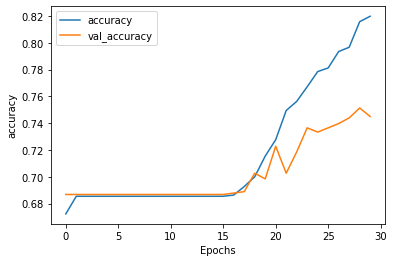

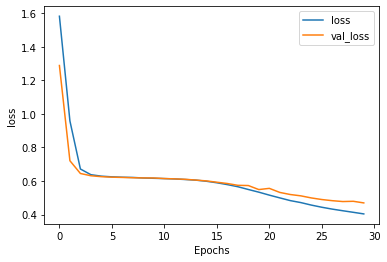

In [10]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [11]:
y_pred = modele.predict(validation_filled)
predictions = np.argmax(y_pred,axis=1)

for i in range(len(predictions)):
    predictions[i] = predictions[i] - 1
    
true_labels = []
for i in y_test:
    if(i=='NotSexist'):
        true_labels.append(0)
    else:
        true_labels.append(1)
    
print("Accuracy : ", np.mean(predictions == true_labels))
metrics.confusion_matrix(true_labels, predictions)

Accuracy :  0.744973544973545


array([[575,  74],
       [167, 129]], dtype=int64)

### Pour la visualisation de nos vecteurs de mots sur https://projector.tensorflow.org/

In [12]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [13]:
e = modele.layers[0]
weights = e.get_weights()[0]
print(weights.shape)

(1000, 16)


In [14]:
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [15]:
#On a essayé d'ajouter des poids à certains mots, malheureusement sans succès
'''import re
stereotype_liste = []

with open('stereotype_liste.txt',encoding='utf8') as f:
    stereotype_liste = f.readlines()

weighted_words = [re.sub(r"\n",'',i) for i in stereotype_liste]

print(weighted_words)

from sklearn.feature_extraction.text import TfidfVectorizer
   
data = pd.read_csv("my_csv_clean.csv",sep = ',') #we got that csv after running the Text Preprocessing file
data.columns = ['tweet', 'class'] 

X = data['tweet']
y = data['class'] 

categories = ["NotSexist", "Sexist"]

vectorizer = TfidfVectorizer()
new_X = vectorizer.fit_transform(X)
vectorizer.get_feature_names_out()'''

'import re\nstereotype_liste = []\n\nwith open(\'stereotype_liste.txt\',encoding=\'utf8\') as f:\n    stereotype_liste = f.readlines()\n\nweighted_words = [re.sub(r"\n",\'\',i) for i in stereotype_liste]\n\nprint(weighted_words)\n\nfrom sklearn.feature_extraction.text import TfidfVectorizer\n   \ndata = pd.read_csv("my_csv_clean.csv",sep = \',\') #we got that csv after running the Text Preprocessing file\ndata.columns = [\'tweet\', \'class\'] \n\nX = data[\'tweet\']\ny = data[\'class\'] \n\ncategories = ["NotSexist", "Sexist"]\n\nvectorizer = TfidfVectorizer()\nnew_X = vectorizer.fit_transform(X)\nvectorizer.get_feature_names_out()'

## Création d'un réseau de neurone à partir de vecteur de mots avec recours à de l'oversampling

In [16]:
data = pd.read_csv("my_csv_clean.csv",sep = ',') #we got that csv after running the Text Preprocessing file
data.columns = ['tweet', 'class']

X = data['tweet']
y = data['class'] 

X_train, X_test, y_train , y_test = train_test_split(X , y ,test_size=0.3)

X = list(X)
y = [categories[i] for i in y]
X_test = list(X_test)
y_train = [categories[i] for i in y_train]
y_test = [categories[i] for i in y_test]

ros = RandomOverSampler()
X_ros_train, y_ros_train = ros.fit_resample(np.array(X_train).reshape(-1,1), y_train)# new class distribution 
X_ros_test, y_ros_test = ros.fit_resample(np.array(X_test).reshape(-1,1), y_test)# new class distribution 
X_ros_train = X_ros_train.tolist()
X_ros_test = X_ros_test.tolist()

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_ros_train)

word_index = tokenizer.word_index
total_words = len(word_index)+1 #1 for oov word

train_sequences = tokenizer.texts_to_sequences(X_ros_train)
train_filled = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

validation_sequences = tokenizer.texts_to_sequences(X_ros_test)
validation_filled = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length)

label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(y)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(y_ros_train))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(y_ros_test))

modele = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])
modele.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
modele.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 120, 16)           16000     
                                                                 
 global_average_pooling1d_1   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 24)                408       
                                                                 
 dense_3 (Dense)             (None, 6)                 150       
                                                                 
Total params: 16,558
Trainable params: 16,558
Non-trainable params: 0
_________________________________________________________________


In [17]:
num_epochs = 30
history = modele.fit(train_filled, training_label_seq, epochs=num_epochs, 
                    validation_data=(validation_filled, validation_label_seq), 
                    verbose=2)

Epoch 1/30
96/96 - 1s - loss: 1.4840 - accuracy: 0.5000 - val_loss: 1.0641 - val_accuracy: 0.5000 - 1s/epoch - 11ms/step
Epoch 2/30
96/96 - 0s - loss: 0.8423 - accuracy: 0.5000 - val_loss: 0.7352 - val_accuracy: 0.5000 - 372ms/epoch - 4ms/step
Epoch 3/30
96/96 - 0s - loss: 0.7169 - accuracy: 0.5072 - val_loss: 0.7060 - val_accuracy: 0.5000 - 359ms/epoch - 4ms/step
Epoch 4/30
96/96 - 0s - loss: 0.7016 - accuracy: 0.5160 - val_loss: 0.6994 - val_accuracy: 0.5000 - 274ms/epoch - 3ms/step
Epoch 5/30
96/96 - 0s - loss: 0.6968 - accuracy: 0.5078 - val_loss: 0.6969 - val_accuracy: 0.4928 - 225ms/epoch - 2ms/step
Epoch 6/30
96/96 - 0s - loss: 0.6950 - accuracy: 0.5144 - val_loss: 0.7002 - val_accuracy: 0.5000 - 211ms/epoch - 2ms/step
Epoch 7/30
96/96 - 0s - loss: 0.6950 - accuracy: 0.4993 - val_loss: 0.6955 - val_accuracy: 0.5000 - 310ms/epoch - 3ms/step
Epoch 8/30
96/96 - 0s - loss: 0.6917 - accuracy: 0.5327 - val_loss: 0.6946 - val_accuracy: 0.4928 - 342ms/epoch - 4ms/step
Epoch 9/30
96/96 -

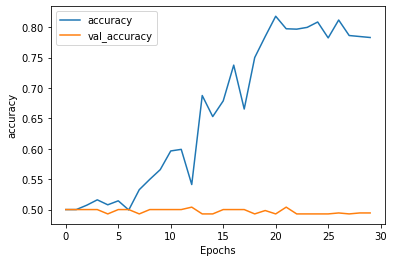

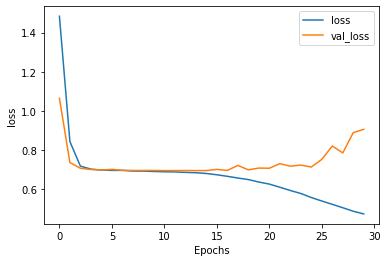

In [18]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [19]:
y_pred = modele.predict(validation_filled)
predictions = np.argmax(y_pred,axis=1)

for i in range(len(predictions)):
    predictions[i] = predictions[i] - 1
    
true_labels = []
for i in y_ros_test:
    if(i=='NotSexist'):
        true_labels.append(0)
    else:
        true_labels.append(1)
print("Accuracy : ", np.mean(predictions == true_labels))
metrics.confusion_matrix(true_labels, predictions)

Accuracy :  0.4944356120826709


array([[617,  12],
       [624,   5]], dtype=int64)

## Création d'un réseau de neurone à partir de vecteur de mots avec recours à de l'undersampling

In [20]:
data = pd.read_csv("my_csv_clean.csv",sep = ',') #we got that csv after running the Text Preprocessing file
data.columns = ['tweet', 'class']

X = data['tweet']
y = data['class'] 

X_train, X_test, y_train , y_test = train_test_split(X , y ,test_size=0.3)

X = list(X)
y = [categories[i] for i in y]
X_test = list(X_test)
y_train = [categories[i] for i in y_train]
y_test = [categories[i] for i in y_test]

rus = RandomUnderSampler()
X_rus_train, y_rus_train = rus.fit_resample(np.array(X_train).reshape(-1,1), y_train)# new class distribution 
X_rus_test, y_rus_test = rus.fit_resample(np.array(X_test).reshape(-1,1), y_test)# new class distribution 
X_rus_train = X_rus_train.tolist()
X_rus_test = X_rus_test.tolist()

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_rus_train)

word_index = tokenizer.word_index
total_words = len(word_index)+1

train_sequences = tokenizer.texts_to_sequences(X_rus_train)
train_filled = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

validation_sequences = tokenizer.texts_to_sequences(X_rus_test)
validation_filled = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length)

label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(y)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(y_rus_train))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(y_rus_test))

modele = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])
modele.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
modele.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 120, 16)           16000     
                                                                 
 global_average_pooling1d_2   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_4 (Dense)             (None, 24)                408       
                                                                 
 dense_5 (Dense)             (None, 6)                 150       
                                                                 
Total params: 16,558
Trainable params: 16,558
Non-trainable params: 0
_________________________________________________________________


In [21]:
num_epochs = 30
history = modele.fit(train_filled, training_label_seq, epochs=num_epochs, 
                    validation_data=(validation_filled, validation_label_seq), 
                    verbose=2)

Epoch 1/30
43/43 - 1s - loss: 1.6817 - accuracy: 0.5000 - val_loss: 1.5595 - val_accuracy: 0.5000 - 871ms/epoch - 20ms/step
Epoch 2/30
43/43 - 0s - loss: 1.3787 - accuracy: 0.5000 - val_loss: 1.1511 - val_accuracy: 0.5000 - 331ms/epoch - 8ms/step
Epoch 3/30
43/43 - 0s - loss: 0.9742 - accuracy: 0.5000 - val_loss: 0.8268 - val_accuracy: 0.5000 - 207ms/epoch - 5ms/step
Epoch 4/30
43/43 - 0s - loss: 0.7695 - accuracy: 0.5000 - val_loss: 0.7329 - val_accuracy: 0.5000 - 142ms/epoch - 3ms/step
Epoch 5/30
43/43 - 0s - loss: 0.7221 - accuracy: 0.4822 - val_loss: 0.7120 - val_accuracy: 0.5000 - 174ms/epoch - 4ms/step
Epoch 6/30
43/43 - 0s - loss: 0.7081 - accuracy: 0.5082 - val_loss: 0.7045 - val_accuracy: 0.5000 - 127ms/epoch - 3ms/step
Epoch 7/30
43/43 - 0s - loss: 0.7020 - accuracy: 0.5141 - val_loss: 0.7010 - val_accuracy: 0.5000 - 117ms/epoch - 3ms/step
Epoch 8/30
43/43 - 0s - loss: 0.6991 - accuracy: 0.5045 - val_loss: 0.6989 - val_accuracy: 0.5000 - 143ms/epoch - 3ms/step
Epoch 9/30
43/4

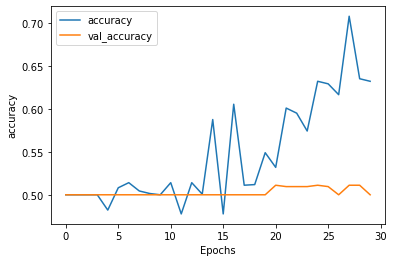

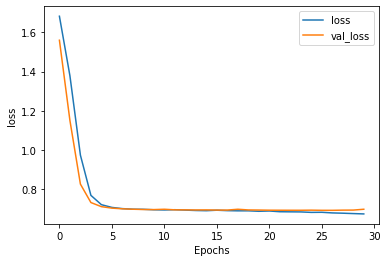

In [22]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [23]:
y_pred = modele.predict(validation_filled)
predictions = np.argmax(y_pred,axis=1)

for i in range(len(predictions)):
    predictions[i] = predictions[i] - 1
    
true_labels = []
for i in y_rus_test:
    if(i=='NotSexist'):
        true_labels.append(0)
    else:
        true_labels.append(1)
    
print("Accuracy : ", np.mean(predictions == true_labels))
metrics.confusion_matrix(true_labels, predictions)

Accuracy :  0.5


array([[  0, 315],
       [  0, 315]], dtype=int64)